In [7]:
opt = {
    'dataset': 'mnist',
    'dataroot': '/',
    'workers': 2,
    'batchSize': 64,
    'imageSize': 28,
    'nz': 100,
    'ngf': 64,
    'ndf': 64,
    'niter': 25,
    'lr': 0.002,
    'beta1': 0.5,
    'cuda': True,
    'ngpu': 1,
    'netG': '',
    'netD': '',
    'outf': ''
#     ,
#     'manualSeed'
    
}


'mnist'

In [61]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
# import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


# parser = argparse.ArgumentParser()
# 'dataset', required=True, help='cifar10 | lsun | mnist |imagenet | folder | lfw | fake')
# 'dataroot', required=True, help='path to dataset')
# 'workers', type=int, help='number of data loading workers', default=2)
# 'batchSize', type=int, default=64, help='input batch size')
# 'imageSize', type=int, default=64, help='the height / width of the input image to network')
# 'nz', type=int, default=100, help='size of the latent z vector')
# 'ngf', type=int, default=64)
# 'ndf', type=int, default=64)
# 'niter', type=int, default=25, help='number of epochs to train for')
# 'lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# 'beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# 'cuda', action='store_true', help='enables cuda')
# 'ngpu', type=int, default=1, help='number of GPUs to use')
# 'netG', default='', help="path to netG (to continue training)")
# 'netD', default='', help="path to netD (to continue training)")
# 'outf', default='.', help='folder to output images and model checkpoints')
# 'manualSeed', type=int, help='manual seed')

# opt = parser.parse_args()

class attr_dict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
opt = attr_dict({
    'dataset': 'mnist',
    'dataroot': '/',
    'workers': 2,
    'batchSize': 64,
    'imageSize': 28,
    'nz': 100,
    'ngf': 64,
    'ndf': 64,
    'niter': 25,
    'lr': 0.002,
    'beta1': 0.5,
    'cuda': True,
    'ngpu': 1,
    'netG': '',
    'netD': '',
    'outf': ''
#     ,
#     'manualSeed'
    
})
print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")


dataset = dset.MNIST(root='.', download=True,
                   transform=transforms.Compose([
                       transforms.Resize(opt.imageSize),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,)),
                   ]))
nc=1

# train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data', train=True, download=True,
#                        transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=64, shuffle=True, **kwargs)

# train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data', train=True, download=True,
#                        transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=64, shuffle=True, **kwargs)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))


print(dataloader)


device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        print(input.shape)
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

criterion = nn.BCELoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

for epoch in range(opt.niter):
    for i, (data, _) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))


{'dataset': 'mnist', 'dataroot': '/', 'workers': 2, 'batchSize': 64, 'imageSize': 28, 'nz': 100, 'ngf': 64, 'ndf': 64, 'niter': 25, 'lr': 0.002, 'beta1': 0.5, 'cuda': True, 'ngpu': 1, 'netG': '', 'netD': '', 'outf': ''}
Random Seed:  6999
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Batc

RuntimeError: sizes must be non-negative

torch.Size([28, 28])


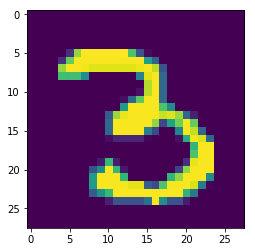

torch.Size([28, 28])


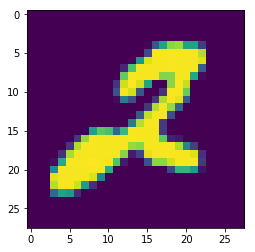

torch.Size([28, 28])


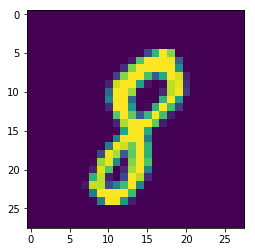

torch.Size([28, 28])


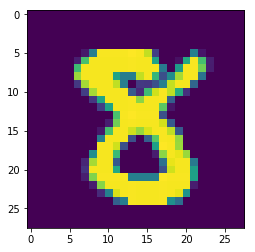

torch.Size([28, 28])


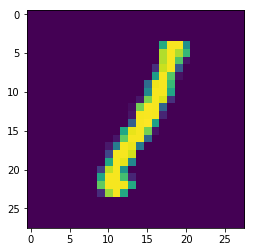

torch.Size([28, 28])


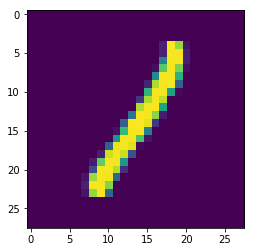

torch.Size([28, 28])


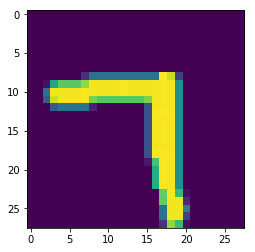

torch.Size([28, 28])


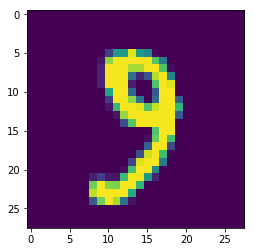

torch.Size([28, 28])


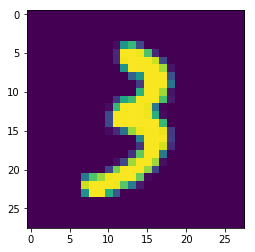

torch.Size([28, 28])


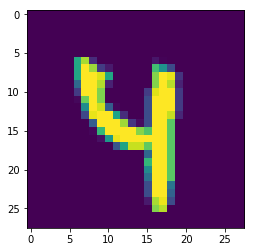

torch.Size([28, 28])


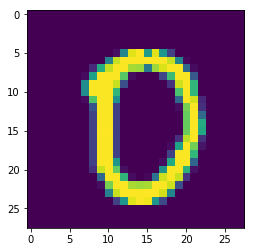

torch.Size([28, 28])


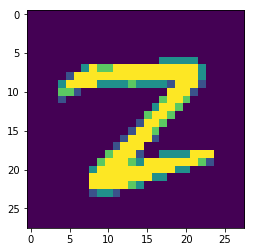

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2d76313dd8>>
Traceback (most recent call last):
  File "/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/u/53/aftenim1/unix/.conda/envs/capsenv/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File

In [57]:
import matplotlib.pyplot as plt
import numpy as np

for i, (data, _) in enumerate(dataloader):
    
    print(data[0][0].shape)
    plt.imshow(data[0][0])
    plt.show()
    if i  > 10: break

# plt.imshow(np.arange(28*28).reshape((28, 28)))
# plt.show()
        